In [18]:
import numpy as np
import torch,torchvision
import copy
from mask2former.utils.misc import is_dist_avail_and_initialized, nested_tensor_from_tensor_list

c = torch.zeros((1,10,20,20), dtype=torch.uint8)
a = torch.zeros((10,20,20))
b = torch.ones((5,20,20))
x = [a,b,c]
# y, _= nested_tensor_from_tensor_list(x).decompose()

In [65]:
x = torch.randn(10, dtype=torch.float32, requires_grad=True)
print(x)
y = x.repeat(5, 1)
z = (y**2).sum()
# z.backward()
torch.autograd.backward([z], inputs=[x])

tensor([-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
         1.3287, -0.3221], requires_grad=True)


In [72]:
optim = torch.optim.SGD([x], lr=0.01)
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()
print(x)  

tensor([-0.1776,  0.4917, -0.6634, -0.4491,  0.0426, -0.6906, -0.3087, -0.3322,
         0.7972, -0.1933], requires_grad=True)
tensor([-0.1480,  0.4098, -0.5529, -0.3743,  0.0355, -0.5755, -0.2572, -0.2768,
         0.6644, -0.1611], requires_grad=True)


In [73]:
y

tensor([[-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
          1.3287, -0.3221],
        [-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
          1.3287, -0.3221],
        [-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
          1.3287, -0.3221],
        [-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
          1.3287, -0.3221],
        [-0.2960,  0.8196, -1.1057, -0.7486,  0.0711, -1.1511, -0.5144, -0.5536,
          1.3287, -0.3221]], grad_fn=<RepeatBackward>)

In [49]:
x = torch.randn(3, 4, requires_grad=True)
print(x)
# def test_repeat(x):
y = x.repeat(2, 2, 2, 2)
out = y.sum()
out.backward()

# test_repeat(x)

tensor([[-0.0929,  1.6599,  0.0832,  0.5620],
        [-0.3079,  2.0893, -1.9158,  1.1371],
        [-0.5511, -0.2064,  0.6665,  0.4380]], requires_grad=True)


In [50]:
optim = torch.optim.SGD([x], lr=0.001)
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()
print(x)  

tensor([[-0.0929,  1.6599,  0.0832,  0.5620],
        [-0.3079,  2.0893, -1.9158,  1.1371],
        [-0.5511, -0.2064,  0.6665,  0.4380]], requires_grad=True)
tensor([[-0.1089,  1.6439,  0.0672,  0.5460],
        [-0.3239,  2.0733, -1.9318,  1.1211],
        [-0.5671, -0.2224,  0.6505,  0.4220]], requires_grad=True)


In [48]:
print(y)

tensor([[[[ 0.5090,  0.8449,  0.9408,  ...,  0.8449,  0.9408, -1.8064],
          [ 0.7442,  1.6614, -0.2069,  ...,  1.6614, -0.2069,  2.8816],
          [-2.0300,  1.2903, -1.7441,  ...,  1.2903, -1.7441,  0.3576],
          ...,
          [ 0.5090,  0.8449,  0.9408,  ...,  0.8449,  0.9408, -1.8064],
          [ 0.7442,  1.6614, -0.2069,  ...,  1.6614, -0.2069,  2.8816],
          [-2.0300,  1.2903, -1.7441,  ...,  1.2903, -1.7441,  0.3576]],

         [[ 0.5090,  0.8449,  0.9408,  ...,  0.8449,  0.9408, -1.8064],
          [ 0.7442,  1.6614, -0.2069,  ...,  1.6614, -0.2069,  2.8816],
          [-2.0300,  1.2903, -1.7441,  ...,  1.2903, -1.7441,  0.3576],
          ...,
          [ 0.5090,  0.8449,  0.9408,  ...,  0.8449,  0.9408, -1.8064],
          [ 0.7442,  1.6614, -0.2069,  ...,  1.6614, -0.2069,  2.8816],
          [-2.0300,  1.2903, -1.7441,  ...,  1.2903, -1.7441,  0.3576]],

         [[ 0.5090,  0.8449,  0.9408,  ...,  0.8449,  0.9408, -1.8064],
          [ 0.7442,  1.6614, -

In [6]:
from mask2former import COCOMultiInstStuffMultiQueriesClicksDatasetMapper, add_maskformer2_config
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former.utils.equal_num_instances_batch import build_detection_train_loader_equal
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
# cfg.merge_from_file("mycfg.yaml")
cfg.merge_from_file("configs/coco/iterative/new/rev_attn_rand_bg_class_agnostic_MQ_MID_stufff_clicks.yaml")

mapper = COCOMultiInstStuffMultiQueriesClicksDatasetMapper(cfg,True)
data_loader =  build_detection_train_loader_equal(cfg, mapper=mapper)

In [7]:
batch = next(iter(data_loader))

In [8]:
len(batch)

8

In [9]:
batch[0]['instances'].gt_masks.shape

torch.Size([1, 512, 512])

In [10]:
import cv2
image = np.asarray(batch[0]["image"].permute(1,2,0))
cv2.imshow("img_window",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
image = np.asarray(batch[0]["instances"].gt_masks[0])
cv2.imshow("img_window",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
batch[0]["instances"].gt_masks[0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [16]:
i=1
x=1
while(True):
    if x==1:
        break
    i+=1
    x+=1

In [2]:
import torch
a = torch.zeros((10,20,20))
b = torch.zeros((10,20,5))
torch.cat((a,b),dim=2).shape                                                                    

/home/rana/anaconda3/envs/m2f/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([10, 20, 25])

In [15]:
def fun(x,y):
    x.append(5)
    y.append(6)
    return x,y
a = [4]
b = [6]
(a,
b) = fun(a,b)
print(a,b)

[4, 5] [6, 6]


In [9]:
a = np.array([1,1.0,0], dtype=np.bool_)
a.sum()

2

In [7]:
a = torch.tensor([1.,2.], requires_grad=True)
b = torch.tensor([2.,3.], requires_grad=True)  
ab = torch.cat((a,b), dim=0) # ab  = tensor([1., 2., 2., 3.], grad_fn=<CatBackward>)
z = ab**2 # z = tensor([1., 4., 4., 9.], grad_fn=<PowBackward0>)
out = z.mean() # out = tensor(4.5000, grad_fn=<MeanBackward0>)
out.backward()
print(a.grad) # tensor([1.5000, 2.5000])
b.grad # tensor([1.5000, 2.5000])

tensor([0.5000, 1.0000])


tensor([1.0000, 1.5000])

In [1]:
from detectron2.evaluation import inference_on_dataset


In [42]:
import pickle
file_path = "all_data/evaluations/sbd_multi_insts/dynamite_swin_tiny_1024_bs64_10_max_click_th_final_updated_time_summary.pickle"

with open(file_path, 'rb') as handle:
    b = pickle.load(handle)
b.keys()

In [198]:
k = ['dataset', 'model', 'iou_threshold', 'failed_images_counts', 'avg_over_total_images', 'Avg_NOC', 'Avg_IOU', 'num_failed_objects']

In [58]:
b['Avg_NOC']

4.48

In [55]:
6671/2857

2.334966748337417

In [50]:
times = b['time_per_image_features']

In [51]:
sum(times)/len(times)

0.14331715965665856

In [52]:
times = b['time_per_image_annotation']
sum(times)/len(times)

0.6641665849995062

In [53]:
times = b['time_per_intreaction_tranformer_decoder']
sum(times)/len(times)

0.038640099109417216

In [59]:
0.038*2.33*4.48 + 0.14


0.5366592

In [228]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["num interactions", "NCI", "NOC", "NFO", "NFI"]
for i in range(6):
    file_path = f"all_data/evaluations/sbd_multi_insts/ablation_iter_{i}_10_max_click_th_final_updated_time_summary.pickle"

    with open(file_path, 'rb') as handle:
        b = pickle.load(handle)
    
    x.add_row([i, np.round(b['avg_over_total_images'],2), b['Avg_NOC'], b['num_failed_objects'], b['failed_images_counts']])


In [229]:
print(x)

+------------------+------+------+------+-----+
| num interactions | NCI  | NOC  | NFO  | NFI |
+------------------+------+------+------+-----+
|        0         | 3.94 | 5.24 | 2024 | 928 |
|        1         | 3.87 | 5.16 | 1854 | 884 |
|        2         | 3.67 | 4.9  | 1682 | 825 |
|        3         | 3.63 | 4.8  | 1566 | 778 |
|        4         | 3.51 | 4.69 | 1566 | 776 |
|        5         | 3.58 | 4.76 | 1576 | 784 |
+------------------+------+------+------+-----+


In [216]:
def get_palette(num_cls):
    palette = np.zeros(3 * num_cls, dtype=np.int32)

    for j in range(0, num_cls):
        lab = j
        i = 0

        while lab > 0:
            palette[j*3 + 0] |= (((lab >> 0) & 1) << (7-i))
            palette[j*3 + 1] |= (((lab >> 1) & 1) << (7-i))
            palette[j*3 + 2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3

    return palette.reshape((-1, 3))
c = get_palette(40)

In [7]:
from mask2former.data.scribble.tamed_robot import TamedRobot
t=TamedRobot()

In [210]:
a= []
a.insert(0,5)
a.append(None)
a[-1] = 10
a

[5, 10]

In [ ]:
import matplotlib.pyplot as plt
areas = b['failed_objects_areas']
bin_size=2
bins  = [sum(areas[i:i+bin_size]) for i in range(0,len(areas)-bin_size, bin_size)] 
print(len(areas))
while(bins[-1] ==0):
    bins.pop()
# print(bins)
# sns.distplot(np.arange(len(bins)), 
#     hist_kws={
#         "weights": bins
#     },
# )

import copy
t = sum(bins[25:])
bins1 = copy.deepcopy(bins[:25])
bins1 = bins1.append(t)
x = bins[:25]
x.append(sum(bins[25:]))
x

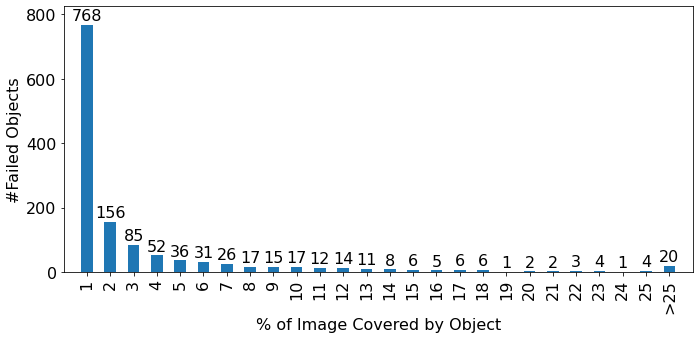

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
# Bring some raw data.
frequencies = x
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = [f"{i+1}" for i in range(len(x)-1)]
x_labels.append(">25")

# Plot the figure.
plt.figure(figsize=(10, 5))
ax = freq_series.plot(kind="bar")
# ax.set_title("Failed Object Areas Distribution")

ax.set_xlabel("% of Image Covered by Object")
ax.set_ylabel("#Failed Objects")
ax.set_xticklabels(x_labels)
ax.set_ylim(0,825)
ax.set_xlim(-1,26)
rects = ax.patches

# Make some labels.
labels = [f"{x[i]}" for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.savefig("a.jpg")
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [3]:
def get_labels_with_sizes(x):
    obj_sizes = np.bincount(x.flatten())
    labels = np.nonzero(obj_sizes)[0].tolist()
    labels = [x for x in labels if x != 0]
    return labels, obj_sizes[labels].tolist()
def get_palette(num_cls):
    palette = np.zeros(3 * num_cls, dtype=np.int32)

    for j in range(0, num_cls):
        lab = j
        i = 0

        while lab > 0:
            palette[j*3 + 0] |= (((lab >> 0) & 1) << (7-i))
            palette[j*3 + 1] |= (((lab >> 1) & 1) << (7-i))
            palette[j*3 + 2] |= (((lab >> 2) & 1) << (7-i))
            i = i + 1
            lab >>= 3

    return palette.reshape((-1, 3))
color_map = get_palette(80)[1:]

In [8]:
import cv2
import os
import torch
import numpy as np
from detectron2.utils.colormap import colormap
# color_map = colormap(rgb=True, maximum=1)

sbd_path = "datasets/sbd/dataset/"
# print(os.path.exists(sbd_path + "img/2008_000051.jpg"))
image_id = "2008_000383"
image = cv2.imread(sbd_path + f"img/{image_id}.jpg")
print(image.shape)
# cv2.imshow("image", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from scipy.io import loadmat
instances_mask = loadmat(str(sbd_path + f"inst/{image_id}.mat"))['GTinst'][0][0][0].astype(np.int32)
labels, _ = get_labels_with_sizes(instances_mask)
print(np.unique(instances_mask))
masks = []
import copy
print(labels)
for label in labels:
    
    temp_masks = copy.deepcopy(instances_mask)
    temp_masks[temp_masks != label] = 0
    temp_masks[temp_masks > 0] = 1
    # m = instances_mask == label
    masks.append(np.asarray(temp_masks, dtype =np.uint8))
masks = torch.from_numpy(np.stack(masks)).to(dtype = torch.uint8)
masks.shape


(375, 500, 3)
[0 1 2 3 4 5 6 7]
[1, 2, 3, 4, 5, 6, 7]


torch.Size([7, 375, 500])

In [9]:
from detectron2.utils.visualizer import Visualizer
image = cv2.imread(sbd_path + f"img/{image_id}.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualizer = Visualizer(image, metadata=None)
# pred_masks = F.resize(result_masks_for_vis.to(dtype=torch.uint8), image.shape[:2])
c = []
for i in range(masks.shape[0]):
    c.append(color_map[i]/255.0)
# pred_masks = np.asarray(pred_masks).astype(np.bool_)
vis = visualizer.overlay_instances(masks = masks, assigned_colors=c, alpha=0.70)
# [Optional] prepare labels

image = vis.get_image()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [66]:
filename = f"output/visual_results/{image_id}.png"
# im = cv2.cvtColor(image,  cv2.COLOR_RGB2BGR)
cv2.imwrite(filename, image)

True

In [3]:
from PIL import Image
davis_path = "datasets/DAVIS/DAVIS-2017-trainval/JPEGImages/480p/"
ann_path = "datasets/DAVIS/DAVIS-2017-trainval/Annotations/480p/"
image_id = "flamingo/00012"
image = cv2.imread(davis_path + f"{image_id}.jpg")
print(image.shape)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# from scipy.io import loadmat
# instances_mask = loadmat(str(sbd_path + f"inst/{image_id}.mat"))['GTinst'][0][0][0].astype(np.int32)
instances_mask = np.array(Image.open(ann_path+f"{image_id}.png").convert("P")).astype(np.uint8)
labels, _ = get_labels_with_sizes(instances_mask)
print(np.unique(instances_mask))
masks = []
import copy
print(labels)
for label in labels:
    
    temp_masks = copy.deepcopy(instances_mask)
    temp_masks[temp_masks != label] = 0
    temp_masks[temp_masks > 0] = 1
    # m = instances_mask == label
    masks.append(np.asarray(temp_masks, dtype =np.uint8))
masks = torch.from_numpy(np.stack(masks)).to(dtype = torch.uint8)
masks.shape

(480, 854, 3)
[0 1]
[1]


torch.Size([1, 480, 854])

In [4]:
from detectron2.utils.visualizer import Visualizer
image = cv2.imread(davis_path + f"{image_id}.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualizer = Visualizer(image, metadata=None)
# pred_masks = F.resize(result_masks_for_vis.to(dtype=torch.uint8), image.shape[:2])
c = []
for i in range(masks.shape[0]):
    c.append(color_map[2*(i)+2])
# pred_masks = np.asarray(pred_masks).astype(np.bool_)
vis = visualizer.overlay_instances(masks = masks, assigned_colors=c, alpha=0.65)
# [Optional] prepare labels

image = vis.get_image()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [80]:
filename = f"output/visual_results/lindy-hop.png"
# im = cv2.cvtColor(image,  cv2.COLOR_RGB2BGR)
cv2.imwrite(filename, image)

True

In [138]:
image =  cv2.imread("failed_v0.png", cv2.COLOR_BGR2RGB)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [139]:
h, w, _ = image.shape
print(image.shape)
h_new = int((2*h)/3)
w_new = int((2*w)/3)
im = cv2.resize(image,(w_new,h_new))
print(im.shape)

(501, 737, 3)
(334, 491, 3)


In [140]:
cv2.imshow("image", im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [141]:
# im = cv2.cvtColor(im,  cv2.COLOR_RGB2BGR)
cv2.imwrite("new_failed_v0.png", im)

True